### Reading the Switchboard Dialog Act Corpus (SwDA)

We are using the **Switchboard Dialog Act Corpus (SwDA)** for our **Call Connect App** project. This dataset consists of **1,155 five-minute telephone conversations** between two participants, annotated with speech act tags. These conversations involve callers questioning receivers on various topics like child care, recycling, and news media. Here’s an overview of the structure, metadata, and how we plan to leverage this data for our app.

---

#### Dataset Highlights:
- **Conversations:** 1,155 telephone conversations
- **Speakers:** 440 participants
- **Utterances:** 221,616 (after processing, we get 122,646 utterances)
- **Topics:** The conversations revolve around prompts like "child care" or "news media," which can be useful in analyzing various conversational aspects.

#### Processed Dataset:
To make this dataset ready for experimentation and modeling, we’re working with a processed version of it. The key modifications include:
- **Disfluencies Removed:** Using regex to clean interruptions and non-verbal sounds that aren’t useful for our analysis.
- **Backchannels Removed:** Utterances with fewer than 5 tokens (such as “uh” or “mm-hmm”) are excluded.
- **Merged Turns:** Successive turns by the same speaker, interrupted by backchannels, are merged to make the conversation flow clearer.

---

#### Dataset Structure

##### 1. **Speaker-Level Metadata**
Each speaker has metadata that helps us understand the conversation dynamics:
- **ID:** Unique identifier for each speaker.
- **Sex:** The gender of the speaker (`MALE` or `FEMALE`).
- **Education:** The speaker’s education level (e.g., 0: Less than high school, 1: Less than college, 2: College, 3: More than college, 9: Unknown).
- **Birth Year:** The year the speaker was born.
- **Dialect Area:** Regional dialect classification (e.g., `SOUTHERN`, `NYC`, `WESTERN`). This will help us tailor our app’s recognition systems.

##### 2. **Utterance-Level Metadata**
Each utterance corresponds to a turn in the conversation. We can use this metadata to structure our app’s responses and interactions:
- **ID:** Formatted as `_conversation_id_`-`_utterance_position_` (e.g., `4325-0`).
- **Speaker:** The person speaking.
- **Text:** The content of the utterance.
- **Tag:** Speech act tags (DAMSL) that classify the type of speech act (e.g., question, request).
- **Alpha Text:** A version with only alphabetic tokens (for processed data).
- **Reply To:** ID of the utterance this replies to (important for understanding conversation flow).
- **Next ID:** ID of the next utterance replying to this one.

##### 3. **Conversation-Level Metadata**
This information helps us track the entire conversation:
- **Filename:** The original file name in the SwDA dataset.
- **Topic Description:** A brief description of the conversation’s topic.
- **Prompt:** A detailed description of the conversation prompt, guiding the flow of conversation.
- **Length:** The duration of the conversation in minutes.
- **From Caller / To Caller:** The identifiers for the participants (A and B).

---

### Combining CSV Files for Model Training
The SwDA dataset is split across multiple CSV files (one for each type of data: conversations, speakers, utterances). To train our models, we’ll need to consolidate these files into a single format that we can use effectively.

#### Steps to Process:
1. **Understand the Files:** We’ll begin by reviewing each file's content (such as the utterances, metadata, and speaker information).
2. **Merge the Data:** We’ll combine the files based on common keys, like `conversation_id`, `speaker_id`, and `utterance_id`, so that all data about a conversation is in one place.
3. **Clean the Data:** We’ll remove any unnecessary or noisy data (e.g., disfluencies, backchannels) to ensure our models only get the most relevant information.

---

### Documentation and References:
- **SwDA Dataset Documentation:** [Switchboard Dialog Dataset Docs](https://convokit.cornell.edu/documentation/switchboard.html)  
- **Original Paper:** [Dialogue Act Modeling for Automatic Tagging and Recognition of Conversational Speech (2000)](https://www.cs.cmu.edu/~ark/QA-data/?ref=hackernoon.com)  

By merging this data into a unified format, we can build more accurate models for understanding conversations in our **Call Connect App**, making it smarter and more capable of handling natural dialogues.

In [4]:
# Importing required libraries
import pandas as pd

# Reading one file from dataset to understand its structure
file_sample = pd.read_csv(r"data\raw\swda\sw00utt\sw_0001_4325.utt.csv")

print("Sample File is:\n")
print(file_sample)

Sample File is:

                swda_filename ptb_basename  conversation_no  transcript_index  \
0    sw00utt/sw_0001_4325.utt     4/sw4325             4325                 0   
1    sw00utt/sw_0001_4325.utt     4/sw4325             4325                 1   
2    sw00utt/sw_0001_4325.utt     4/sw4325             4325                 2   
3    sw00utt/sw_0001_4325.utt     4/sw4325             4325                 3   
4    sw00utt/sw_0001_4325.utt     4/sw4325             4325                 4   
..                        ...          ...              ...               ...   
154  sw00utt/sw_0001_4325.utt     4/sw4325             4325               154   
155  sw00utt/sw_0001_4325.utt     4/sw4325             4325               155   
156  sw00utt/sw_0001_4325.utt     4/sw4325             4325               156   
157  sw00utt/sw_0001_4325.utt     4/sw4325             4325               157   
158  sw00utt/sw_0001_4325.utt     4/sw4325             4325               158   

    act_ta

### Columns of the dataset

In [7]:
print("Columns are:\n")

print(file_sample.columns)

Columns are:

Index(['swda_filename', 'ptb_basename', 'conversation_no', 'transcript_index',
       'act_tag', 'caller', 'utterance_index', 'subutterance_index', 'text',
       'pos', 'trees', 'ptb_treenumbers'],
      dtype='object')


### **1. Merging Code**
This code recursively reads all `.csv` files from the `data\raw\swda` directory and merges them row-wise into a single DataFrame. 

In [29]:
import os
import pandas as pd

# Directory path
data_dir = "data/raw/swda"

# List to store DataFrames
dataframes = []

# Counter for processed files
file_count = 0

# Recursively find all CSV files in the directory
for root, _, files in os.walk(data_dir):  # Traverse subdirectories
    for file in files:
        if file.endswith(".csv") and file != "swda-metadata.csv":  # Ignore swda-metadata.csv
            file_path = os.path.join(root, file)
            print(f"Processing file: {file_path}")  # Log the file path
            try:
                df = pd.read_csv(file_path)  # Read the CSV file
                dataframes.append(df)  # Append to list
                file_count += 1  # Increment file counter
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")  # Handle read errors

# Concatenate all DataFrames row-wise
merged_df = pd.concat(dataframes, ignore_index=True)

# Ensure size is less than 14 MB
while merged_df.memory_usage(deep=True).sum() > 14 * 1024 * 1024:
    merged_df = merged_df.sample(frac=0.9, random_state=42)  # Reduce size by sampling rows

# Display the structure of the merged DataFrame
print("\nMerged Dataset Summary:")
print(f"Shape: {merged_df.shape}")
print(f"Columns: {list(merged_df.columns)}")
print(f"Memory usage: {merged_df.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")

# Total number of files processed
print(f"\nTotal number of files processed (excluding swda-metadata.csv): {file_count}")

Processing file: data/raw/swda\sw00utt\sw_0001_4325.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0002_4330.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0003_4103.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0004_4327.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0005_4646.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0006_4108.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0007_4171.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0008_4321.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0009_4329.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0010_4356.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0011_4358.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0012_4360.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0013_4617.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0014_4619.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0015_4877.utt.csv
Processing file: data/raw/swda\sw00utt\sw_0016_3389.utt.csv
Processing file: data/raw/swda\sw00utt\s

### **2. Descriptive Statistics**
After merging, analyze the merged dataset.

In [33]:
# Display Column names
print("Column Names:")
print(merged_df.columns)

# Display basic statistics
print("\nBasic Statistics:")
print(merged_df.describe(include='all'))  # Include all columns

# Check for missing values
print("\nMissing Values:")
print(merged_df.isnull().sum())

# Display data types
print("\nData Types:")
print(merged_df.dtypes)

# Check unique values in each column
print("\nUnique Values Per Column:")
print({col: merged_df[col].nunique() for col in merged_df.columns})


Column Names:
Index(['swda_filename', 'ptb_basename', 'conversation_no', 'transcript_index',
       'act_tag', 'caller', 'utterance_index', 'subutterance_index', 'text',
       'pos', 'trees', 'ptb_treenumbers'],
      dtype='object')

Basic Statistics:
                   swda_filename ptb_basename  conversation_no  \
count                      22019        21474     22019.000000   
unique                      1155         1269              NaN   
top     sw03utt/sw_0394_2427.utt     2/sw2427              NaN   
freq                          60           60              NaN   
mean                         NaN          NaN      3067.690903   
std                          NaN          NaN       690.442732   
min                          NaN          NaN      2005.000000   
25%                          NaN          NaN      2539.000000   
50%                          NaN          NaN      2962.000000   
75%                          NaN          NaN      3455.000000   
max                 

### **3. Visualization**
We’ll visualize key aspects of the dataset using `matplotlib` and `seaborn`.


Visualizing Categorical Columns...


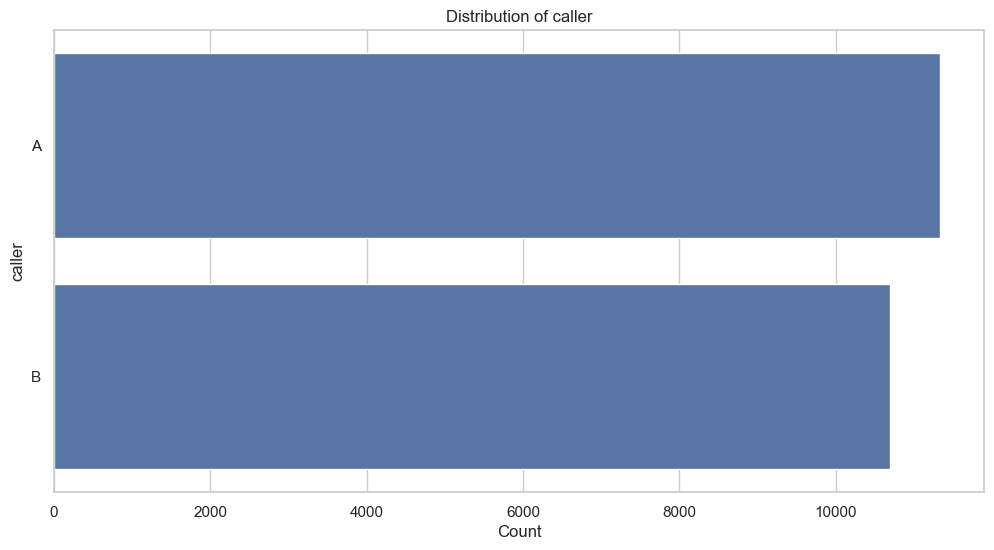

Visualizing Numerical Columns...


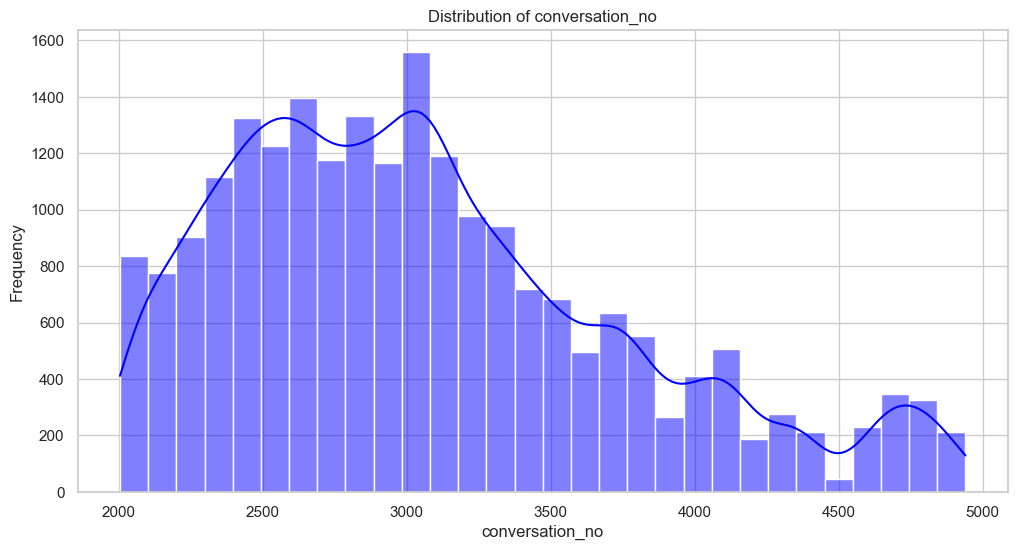

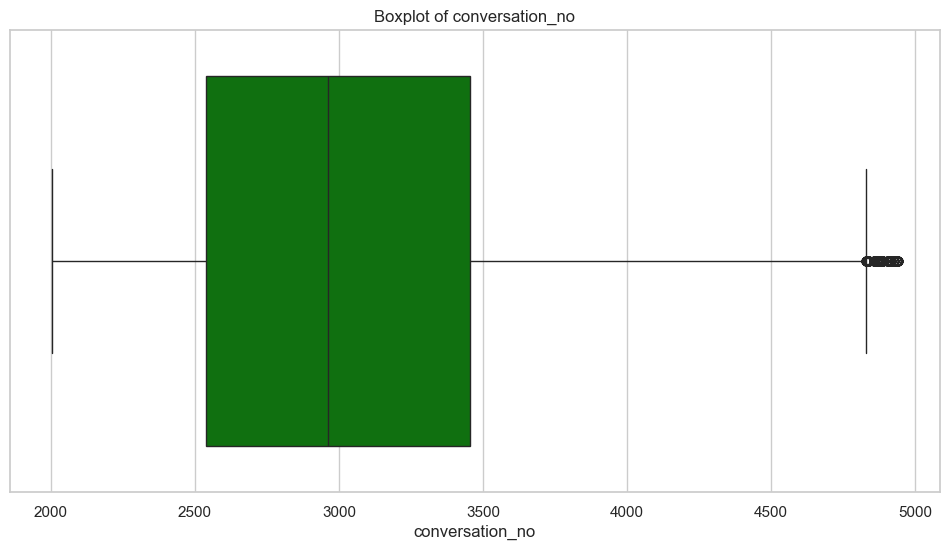

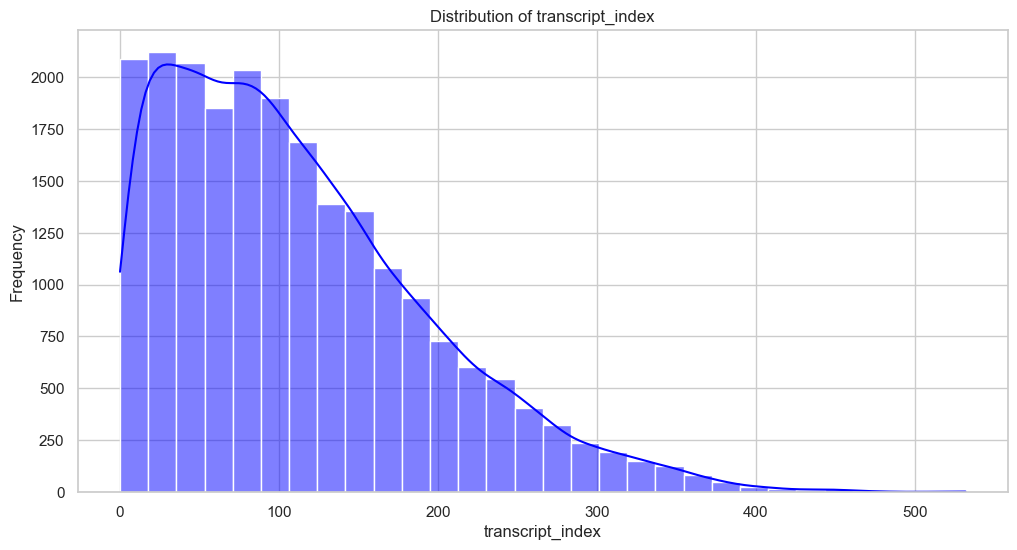

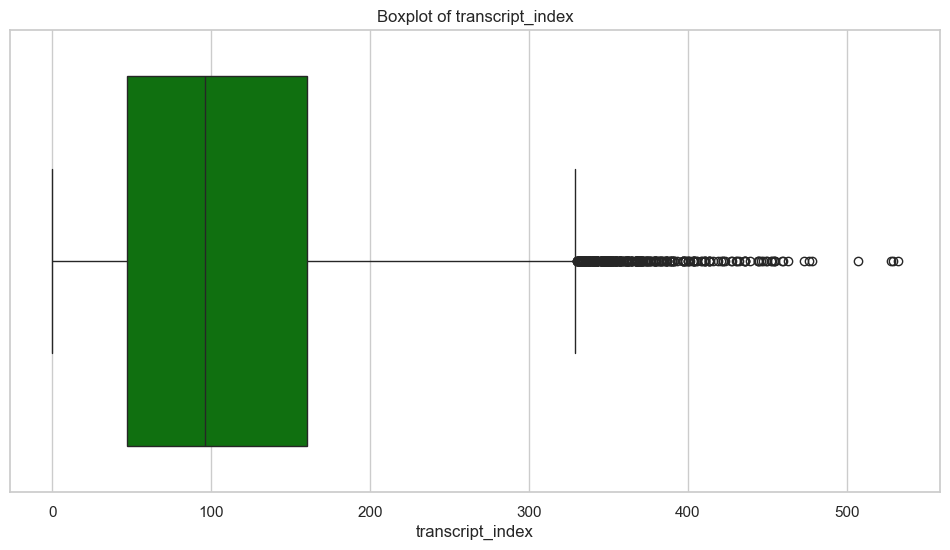

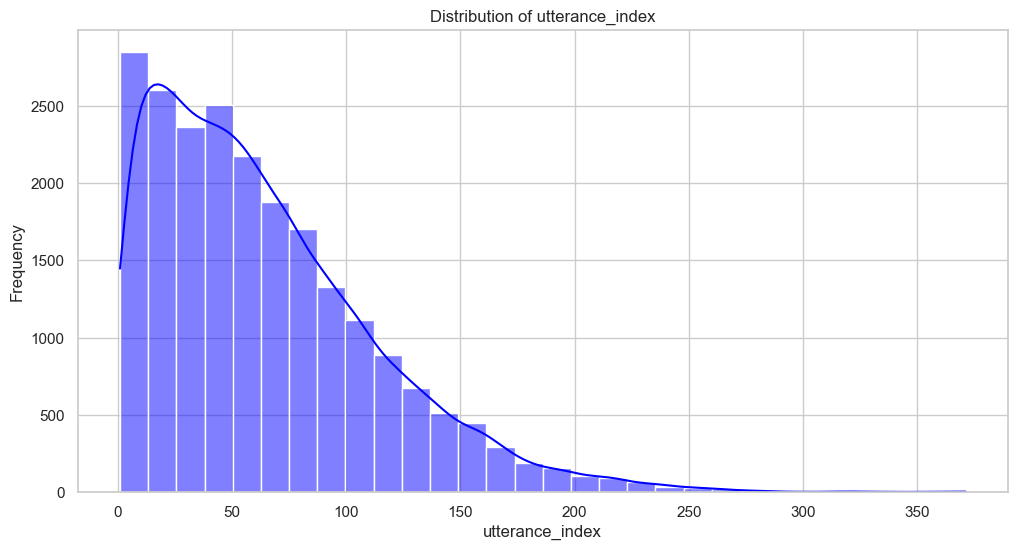

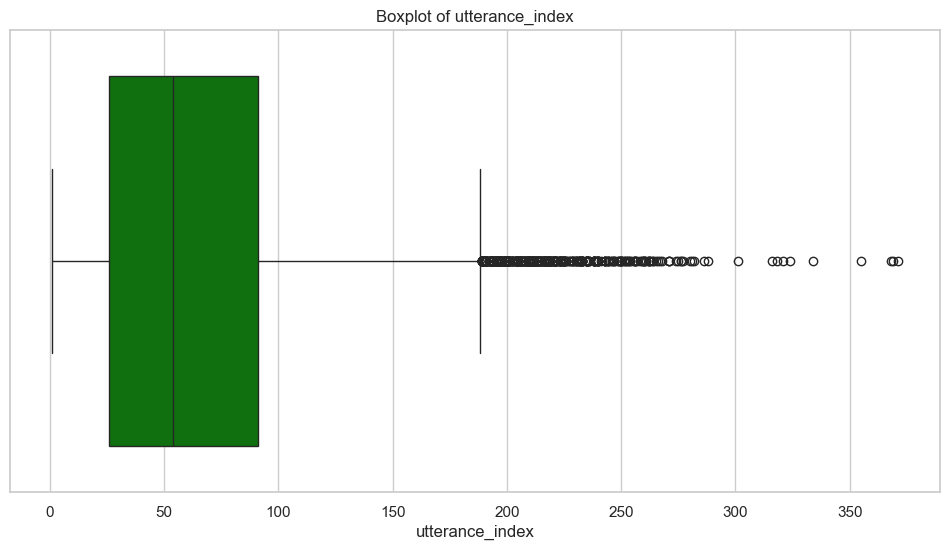

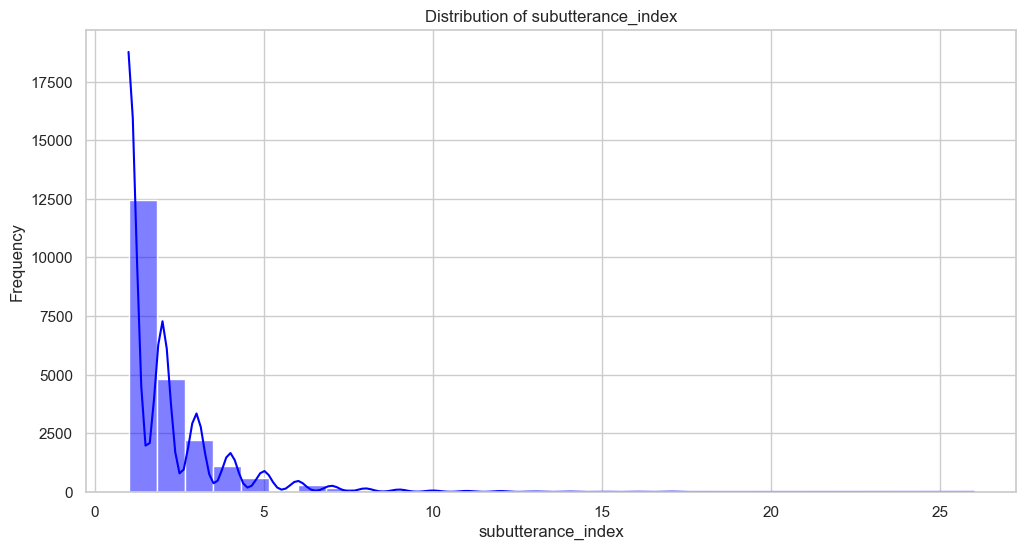

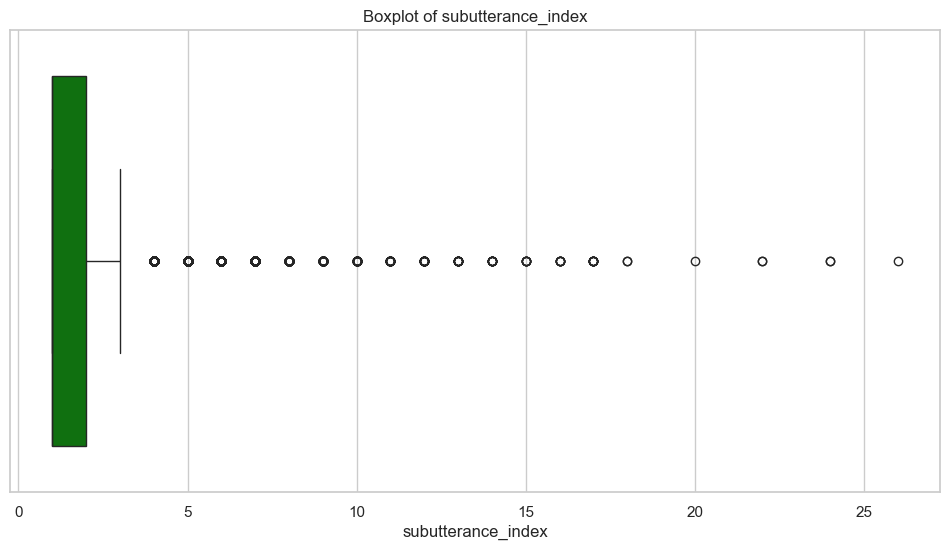

Visualizing Correlations...


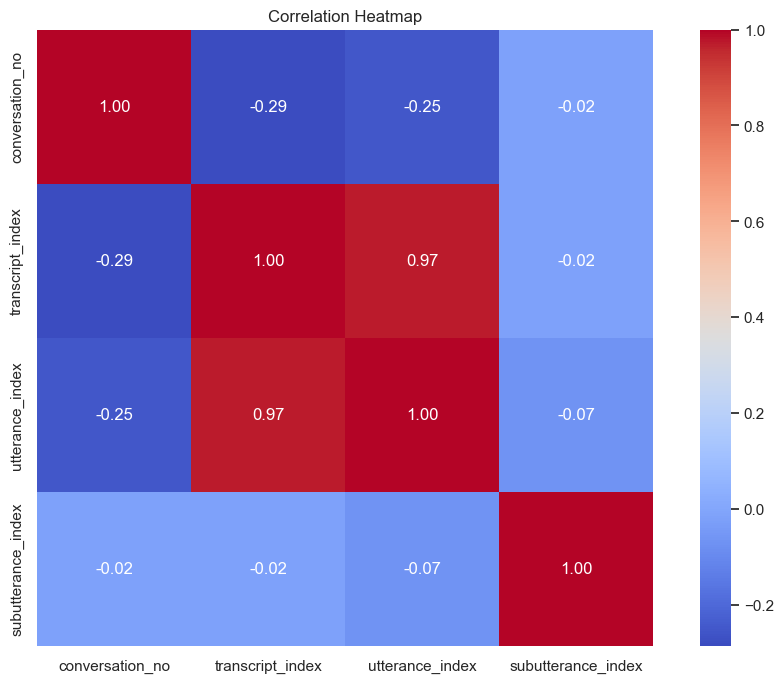

Visualizing Missing Data...


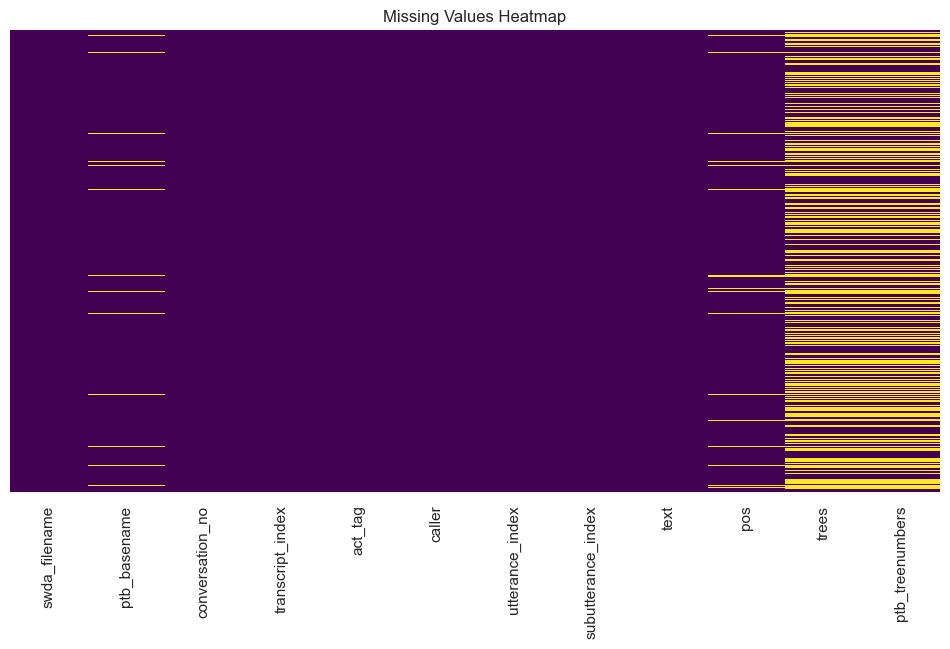

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn pastel style
sns.set_palette("pastel")
sns.set(style="whitegrid")

# Function to visualize categorical columns
def plot_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].nunique() <= 30:  # Only plot for columns with <= 30 unique values
            plt.figure(figsize=(12, 6))
            sns.countplot(data=df, y=col, order=df[col].value_counts().index)
            plt.title(f"Distribution of {col}")
            plt.xlabel("Count")
            plt.ylabel(col)
            plt.show()

# Function to visualize numerical columns
def plot_numerical_columns(df):
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        plt.figure(figsize=(12, 6))
        sns.histplot(df[col], kde=True, bins=30, color="blue")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x=col, color="green")
        plt.title(f"Boxplot of {col}")
        plt.xlabel(col)
        plt.show()

# Plot correlation heatmap for numerical columns
def plot_correlation_heatmap(df):
    numerical_cols = df.select_dtypes(include=['number']).columns
    if len(numerical_cols) > 1:
        plt.figure(figsize=(12, 8))
        sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
        plt.title("Correlation Heatmap")
        plt.show()

# Function to visualize missing values
def plot_missing_data_heatmap(df):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()

# Plot distributions and relationships
print("Visualizing Categorical Columns...")
plot_categorical_columns(merged_df)

print("Visualizing Numerical Columns...")
plot_numerical_columns(merged_df)

print("Visualizing Correlations...")
plot_correlation_heatmap(merged_df)

print("Visualizing Missing Data...")
plot_missing_data_heatmap(merged_df)

### **4. Saving the Final Output**
Finally, save the processed dataset to a `.csv` file, ensuring it fits within 14 MB.

In [37]:
output_file = "data/final/merged_dataset.csv"

# Save the DataFrame to a CSV file
merged_df.to_csv(output_file, index=False)

print(f"Final dataset saved to {output_file}")

Final dataset saved to data/final/merged_dataset.csv
